## This Notebook gives an overview of the Dataset with basic Analysis and Insights

#  <font color='red'>Table of Contents</font>

[1. Business Problem and Use of Deep Learning](#section1)<br>
[2. Visualization of Images](#section2)<br>
[3. Image Processing](#section3)<br>
[4. TSNE Visualization](#section4)<br>
[5. Data Augmentation](#section5)<br>

In [1]:
#ref - https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings

# Basic Libs..
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
import os
print('CWD is ',os.getcwd())

# Vis Libs..
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False

# Image Libs.
from PIL import Image
import cv2

# DL Libs..
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img,load_img
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

ModuleNotFoundError: No module named 'prettytable'

#  <a id = 'section1'> <font color='red'>  1. Business Problem and Use of Deep Learning</font> </a>

### <font color='red'> 1.1 Business Problem Description </font>

##### This case study is based on a Kaggle Competition conducted 7 months back based on a dataset by Aravind Eye Hospital in India to detect a form of Blindness called Diabetic Retinopathy. https://www.kaggle.com/c/aptos2019-blindness-detection/overview is the link to the Kaggle competition. 

### <font color='red'> 1.2 Use of Deep Learning </font>

##### The goal here is to Build an Image Classification Model which can take a look at the images and classify the image into one of the 5 classes (0,1,2,3,4). This Image Classification Model can accelerate the process of Blindness Detection in Patients. Currently Doctors review the Image and classify it into one of the classes - 

##### 0 - No DR
##### 1 - Mild
##### 2 - Moderate
##### 3 - Severe
##### 4 - Proliferative DR

##### Training data contains 3662 images, test data contains 1928 images

### <font color='red'> 1.3 Evaluation Metric </font>

##### The evaluation metric used is Quadratic Weighted Kappa score - https://www.kaggle.com/c/aptos2019-blindness-detection/overview/evaluation

In [3]:
'''
This function reads data from the respective train and test directories
'''

def load_data():
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    
    train_dir = os.path.join('./','train_images/')
    test_dir = os.path.join('./','test_images/')
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))
    
    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    test['file_name'] = test["id_code"].apply(lambda x: x + ".png")
    
    train['diagnosis'] = train['diagnosis'].astype(str)
    
    return train,test

In [4]:
# ref - https://stackoverflow.com/questions/10628262/inserting-image-into-ipython-notebook-markdown

<img src="eval_metric_img.jpg">

#  <a id = 'section2'> <font color='red'>  2. Visualization of Images</font> </a>

In [5]:
df_train,df_test = load_data()
print(df_train.shape,df_test.shape,'\n')
df_train.head(6)

FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

### <font color='red'> 2.1 Class Distribution </font>

In [ ]:
'''This Function Plots a Bar plot of output Classes Distribution'''

def plot_classes(df):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution')
    plt.show() 

In [ ]:
plot_classes(df_train)

##### Plot Summary - As we can see, there is class imbalance in the output class distribution. We shall account for this while training the models using data augmentation / class balancing methods

### <font color='red'> 2.2 Visualize Images </font>

In [6]:
# Defining a global variable to be used as Image size..
IMG_SIZE = 200

In [7]:
'''This Function converts a color image to gray scale image'''

def conv_gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    return img
  
    
'''
This Function shows the visual Image photo of 'n x 5' points (5 of each class)
'''

def visualize_imgs(df,pts_per_class,color_scale):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            if color_scale == 'gray':
                img = conv_gray(cv2.imread(df_temp.file_path.iloc[i]))
                axarr[i].imshow(img,cmap = color_scale)
            else:
                axarr[i].imshow(Image.open(df_temp.file_path.iloc[i]).resize((IMG_SIZE,IMG_SIZE)))
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

In [8]:
visualize_imgs(df_train,3,color_scale = None)

NameError: name 'df_train' is not defined

In [9]:
visualize_imgs(df_train,2,color_scale = 'gray')

NameError: name 'df_train' is not defined

##### Plot summary - As we can see, as we move towards higher classes, we are able to comprehend larger number of abnormalities in the eye images. Also, the lightning and brightness conditions are not even across all images. We will try to handle this using image processing techniques. Also, Gray Scale Images are giving better visualization of the eye features as compared to RGB images

#### ref - https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy
##### This below photo shows what the eye diabetic retinopathy condition refers to using the reference link from the above kaggle kernel

<img src="sample_eye_img.jpg">

#  <a id = 'section3'> <font color='red'>  3. Image Processing</font> </a>

### <font color='red'> 3.1 Gaussian Blur </font>

In [ ]:
# reference - https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy#3.-Further-improve-by-auto-cropping

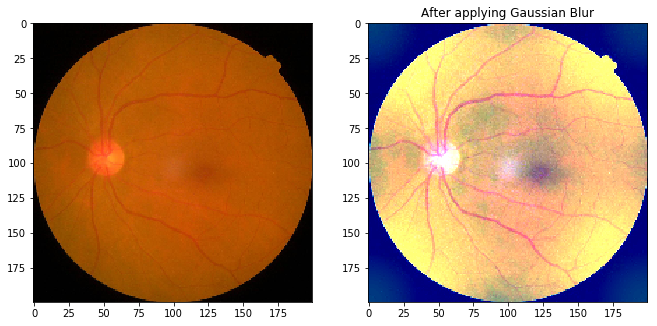

In [15]:
'''
This section of code applies gaussian blur on top of image
'''

rn = np.random.randint(low = 0,high = len(df_train) - 1)

img = cv2.imread(df_train.file_path.iloc[rn])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

img_t = cv2.addWeighted(img,4, cv2.GaussianBlur(img , (0,0) , 30) ,-4 ,128)

f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(img)
axarr[1].imshow(img_t)
plt.title('After applying Gaussian Blur')
plt.show()

##### Plot summary - As we can see, after applying Gaussian Blur, We are able to bring out the features/image details much more clearer in the eye.

### <font color='red'> 3.2 Gaussian Blur with Circular Cropping </font>

In [386]:
'''
This Function performs image processing on top of images by performing Gaussian Blur and Circle Crop
'''

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
    
def circle_crop(img, sigmaX):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

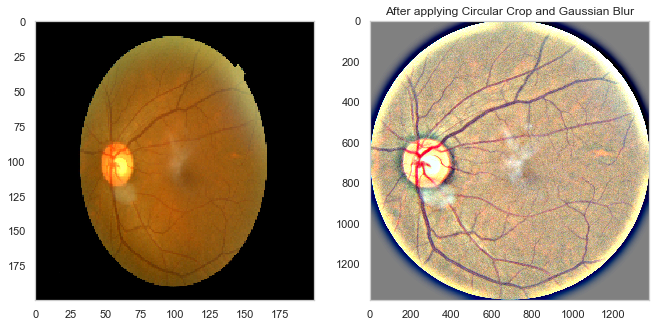

In [384]:
'''Perform Image Processing on a sample image'''

rn = np.random.randint(low = 0,high = len(df_train) - 1)

#img = img_t
img = cv2.imread(df_train.file_path.iloc[rn])
img_t = circle_crop(img,sigmaX = 30)

f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),(IMG_SIZE,IMG_SIZE)))
axarr[1].imshow(img_t)
plt.title('After applying Circular Crop and Gaussian Blur')
plt.show()

##### Plot summary - As we can see above, now the image features and details are very much clearer than what the image was before, we are ready to use this image for modelling as the image details are much more clearer

In [385]:
# ref - https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy
'''
This Function shows the visual Image photo of 'n x 5' points (5 of each class) 
and performs image processing (Gaussian Blur, Circular crop) transformation on top of that
'''

def visualize_img_process(df,pts_per_class,sigmaX):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            img = cv2.imread(df_temp.file_path.iloc[i])
            img = circle_crop(img,sigmaX)
            axarr[i].imshow(img)
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

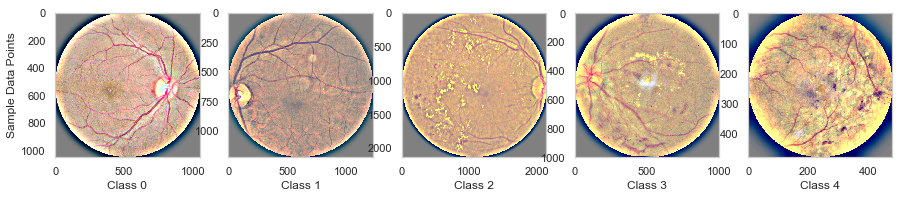

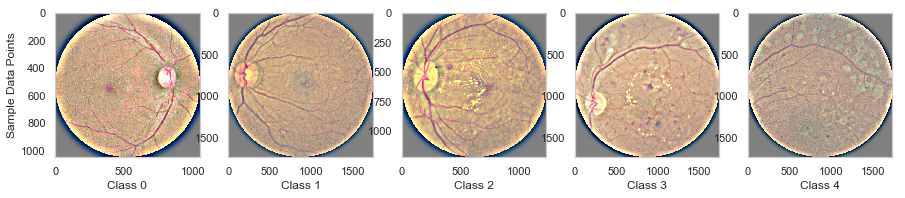

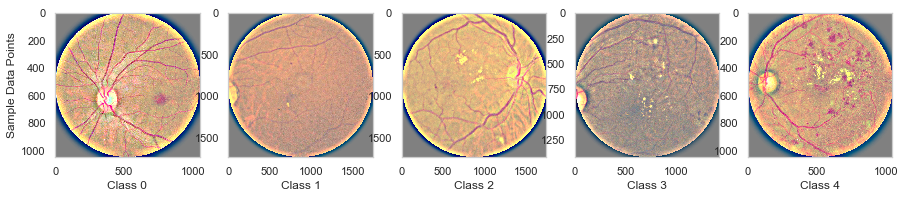

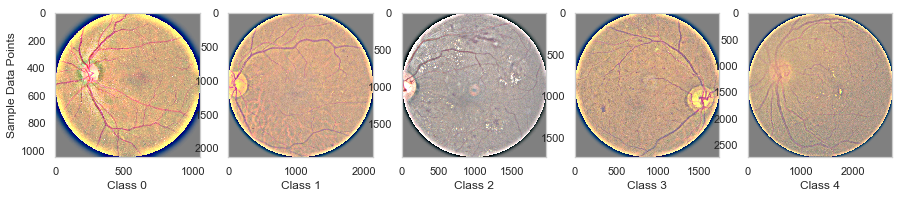

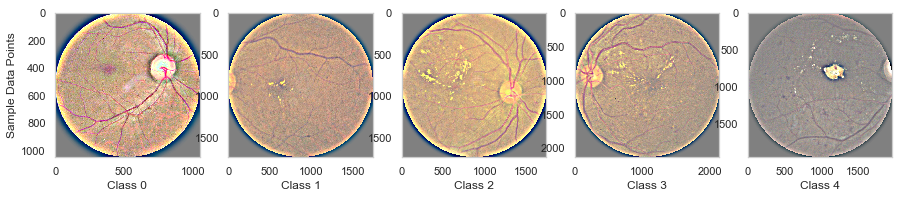

In [387]:
visualize_img_process(df_train,5,sigmaX = 30)

##### Visualizations Summary - Clearly we understand the importance of performing image processing operations here. We have performed Gaussian Blur to bring out the image details and features much more clearly and explicitly. 

#  <a id = 'section4'> <font color='red'>  4. TSNE Visualization</font> </a>

In [ ]:
'''
The code below applies TSNE on Gray Scale Images - The Image is flattened to 2D Gray Image to 1D and then applies TSNE
'''

In [ ]:
# ref - https://www.kaggle.com/code1110/are-there-clusters-pca-tsne-vae

In [391]:
# train image data
npix = 224 # resize to npix x npix (for now)
X_train = np.zeros((df_train.shape[0], npix, npix))
for i in tqdm_notebook(range(df_train.shape[0])):
    # load an image
    img = cv2.imread(df_train.file_path.iloc[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    X_train[i, :, :] = cv2.resize(img, (npix, npix)) 
    
print("X_train shape: " + str(np.shape(X_train)))   


X_train shape: (3662, 224, 224)


In [467]:
# normalize
X = X_train / 255

# reshape
X = X.reshape(X.shape[0], -1)
trainy = df_train['diagnosis']

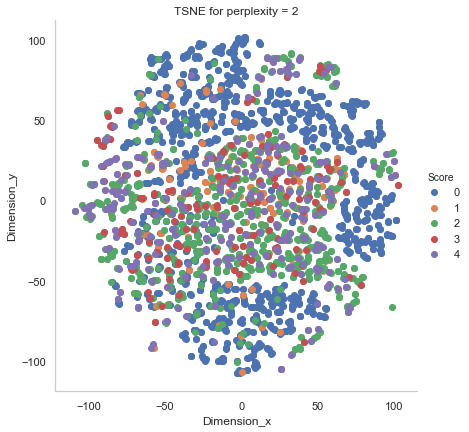

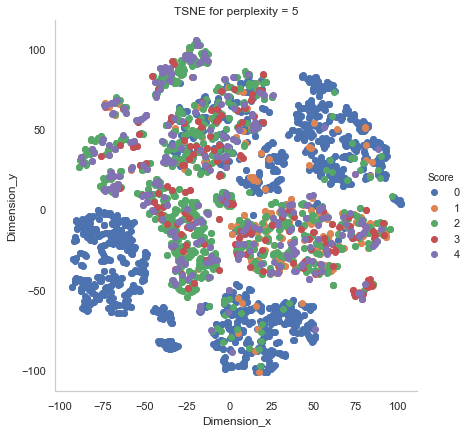

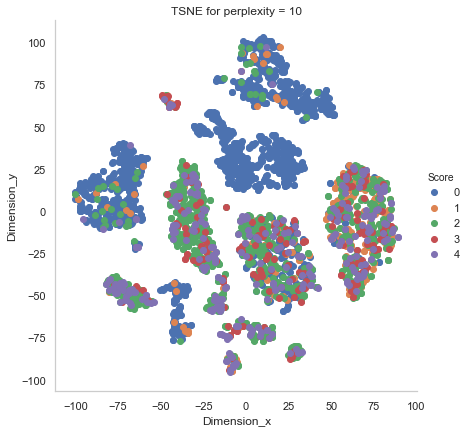

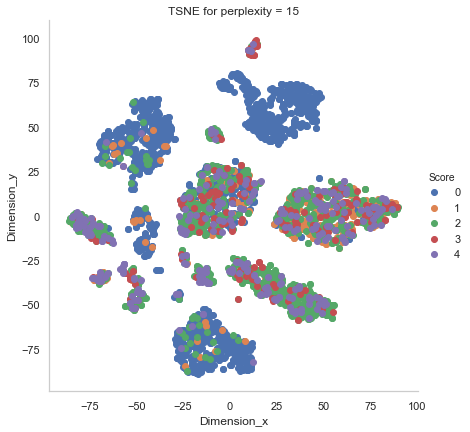

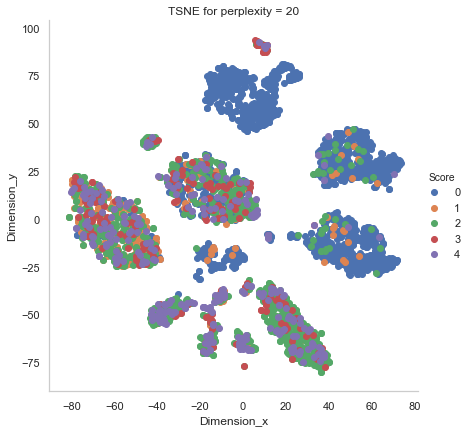

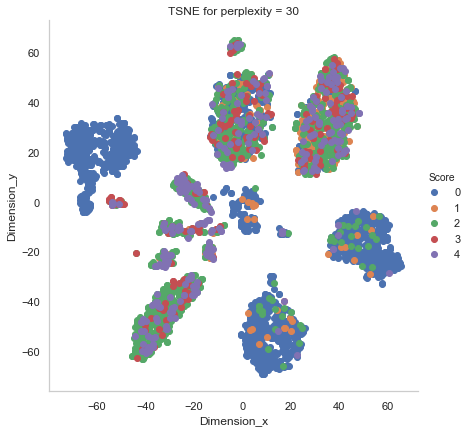

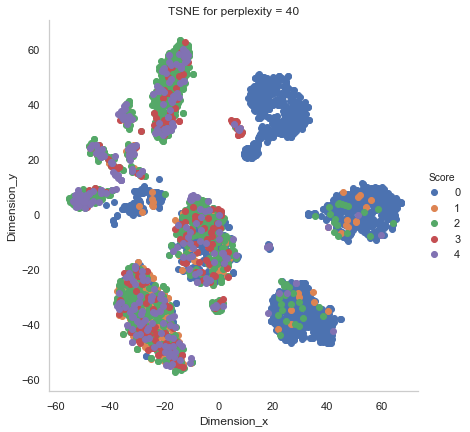

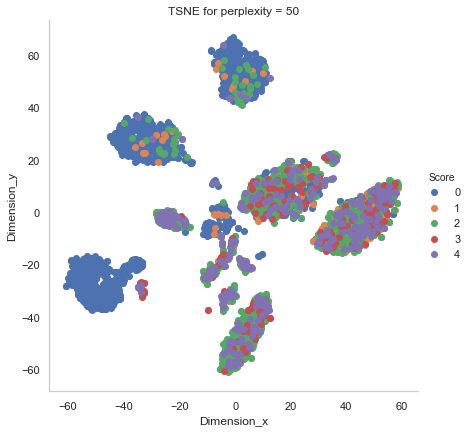

In [475]:
per_vals = [2,5,10,15,20,30,40,50]

for per in tqdm_notebook(per_vals):
    X_decomposed = TSNE(n_components=2,perplexity = per).fit_transform(X)
    df_tsne = pd.DataFrame(data=X_decomposed, columns=['Dimension_x','Dimension_y'])
    df_tsne['Score'] = trainy.values
    
    sns.FacetGrid(df_tsne, hue='Score', size=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
    plt.title('TSNE for perplexity = ' + str(per))
    plt.show()

##### Plot summary - As we can see, we are able to seperate Class '0' from other classes (1-4). Seperating between classes 1-4 looks challenging.

#  <a id = 'section5'> <font color='red'>  5. Data Augmentation</font> </a>

In [21]:
# ref - https://www.youtube.com/watch?v=hxLU32zhze0
# ref - https://stackoverflow.com/questions/49643907/clipping-input-data-to-the-valid-range-for-imshow-with-rgb-data-0-1-for-floa
# ref - https://keras.io/preprocessing/image/

'''This Function generates 'lim' number of Image Augmentations from a random Image in the directory'''

def generate_augmentations(lim):
    datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=20,
                                 #width_shift_range=0.2,
                                 #height_shift_range=0.2,
                                 horizontal_flip=True)
    img = cv2.imread(df_train.file_path.iloc[np.random.randint(low = 0,high = len(df_train) - 1)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.title('ORIGINAL IMAGE')
    plt.show()
    
    img_arr = img.reshape((1,) + img.shape)
    
    i = 0
    for img_iterator in datagen.flow(x = img_arr,batch_size = 1):
        i = i + 1
        if i > lim:
            break
        plt.imshow((img_iterator.reshape(img_arr[0].shape)).astype(np.uint8))
        plt.title('IMAGE AUGMENTATION ' + str(i))
        plt.show() 

In [10]:
generate_augmentations(4)

NameError: name 'generate_augmentations' is not defined

##### Plot Summary - As we can see above, Image Augmentations are extremely helpful for this datasets to make our Models more Robust and would also have a higher ability to generalize well